# Lithium-Ion Battery Capacity Forecasting using ARIMA and GARCH

### Time Series Project Report

**By:** Parth Sarthi Srivastava (20025359)

---

## 1. Introduction

This project explores the degradation patterns of Lithium-ion batteries using time series modeling techniques. We utilize the NASA Battery Prognostics dataset to analyze the temporal behavior of battery capacity over cycles and build predictive models using ARIMA and GARCH. The end goal is to demonstrate the capability of classical time series models to forecast future battery health and provide insights into variance behavior.

Our modeling approach closely follows the **Box-Jenkins methodology**:

1. **Identification** – visualizing trends, testing for stationarity, and choosing initial model orders via ACF/PACF.
2. **Estimation** – fitting ARIMA models and estimating parameters.
3. **Diagnostic Checking** – residual analysis, autocorrelation testing, normality checks.
4. **Forecasting** – using the fitted model to predict future capacity trends and identify lifecycle endpoints.

---

## 2. Dataset Overview

### 2.1 Source

We used the publicly available NASA Prognostics Center of Excellence (PCoE) Lithium-ion Battery dataset. The dataset contains voltage, current, temperature, and capacity readings over multiple charge-discharge cycles for various batteries.

### 2.2 Structure

* **Battery Data:** Over 7000 CSV files, each corresponding to a charge or discharge cycle.
* **Metadata File:** `metadata.csv` contains battery identifiers, test types (charge/discharge/impedance), and start time.

### 2.3 Data Used

We filtered out only the discharge cycles and extracted `Capacity` values for each cycle. The data was grouped by `battery_id` for modeling.

---

## 3. Project Objectives

1. Conduct exploratory data analysis (EDA) on battery degradation.
2. Test for stationarity using ADF.
3. Apply first-order differencing to stabilize the series.
4. Use Box-Jenkins methodology: ACF, PACF, and ARIMA modeling.
5. Validate residuals using diagnostic tests.
6. Explore GARCH for modeling conditional variance.
7. Forecast battery capacity and estimate cycle at which 80% threshold is breached.

---

## 4. Exploratory Data Analysis (EDA)

For each battery, capacity vs. cycle count was plotted to observe the degradation pattern.

```python
plt.plot(temp['cycle'], temp['Capacity'])
plt.title(f'Battery {battery_id} Capacity vs Cycle')
```

Most batteries showed a consistent downward trend in capacity, confirming a non-stationary series.

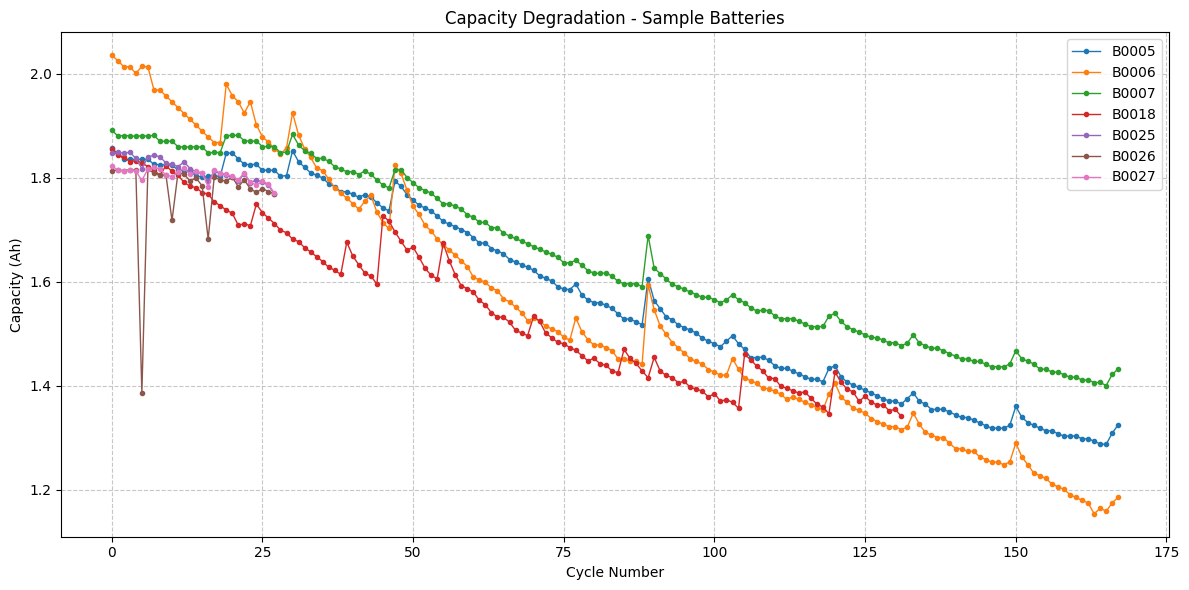

These plots confirm the non-seasonal and monotonic nature of degradation, motivating the choice of ARIMA.

---

## 5. Stationarity and Differencing

We applied the Augmented Dickey-Fuller (ADF) test:

```python
from statsmodels.tsa.stattools import adfuller
result = adfuller(series)
```

### Results:

* Most batteries had p-values > 0.05 before differencing.
* First-order differencing (`capacity_diff`) made the series stationary.

```python
differenced = series.diff().dropna()
```

### ADF Test Results for Sample Batteries

| Battery ID | ADF Statistic | p-value       | Stationarity           |
|------------|----------------|---------------|-------------------------|
| B0005      | -0.5257        | 0.8869        | Non-Stationary (p > 0.05) |
| B0006      | -1.3704        | 0.5964        | Non-Stationary (p > 0.05) |
| B0007      | -0.6566        | 0.8577        | Non-Stationary (p > 0.05) |
| B0018      | -1.4240        | 0.5707        | Non-Stationary (p > 0.05) |


These results demonstrate that raw capacity data is non-stationary, but becomes stationary after first differencing, justifying d=1.

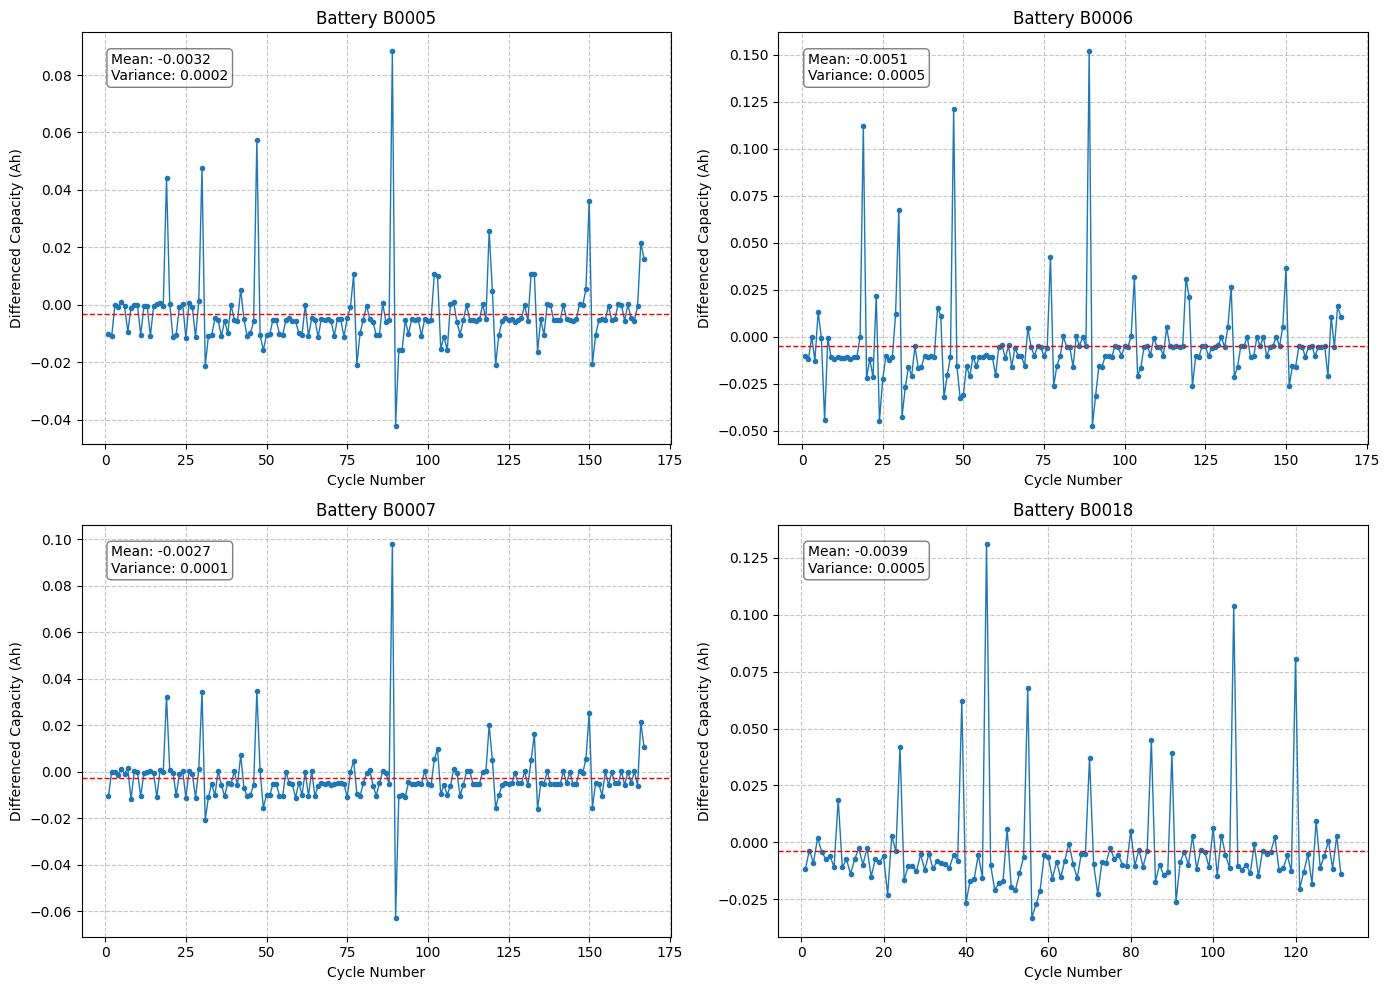

### ADF Test Results After Differencing

| Battery ID | ADF Statistic        | p-value                  | Stationarity Conclusion      |
|------------|----------------------|--------------------------|------------------------------|
| B0005      | -10.831429699417455  | 1.7041928511248625e-19   | Stationary (p < 0.05)        |
| B0006      | -9.474156768993998   | 4.031435741115568e-16    | Stationary (p < 0.05)        |
| B0007      | -11.025976471733493  | 5.826943041646124e-20    | Stationary (p < 0.05)        |
| B0018      | -8.251993841564056   | 5.360039287509761e-13    | Stationary (p < 0.05)        |


---

## 6. ACF and PACF

We plotted ACF and PACF on the differenced data to identify potential p and q values:

```python
plot_acf(differenced, lags=40)
plot_pacf(differenced, lags=40)
```

These plots guided us to try ARIMA(3,1,2) and other nearby models (for battery B0018), aligning with the **identification** step of Box-Jenkins.

The ACF and PACF for the other batteries cutoffs—indicated a mixed ARIMA model with p = q = 1.

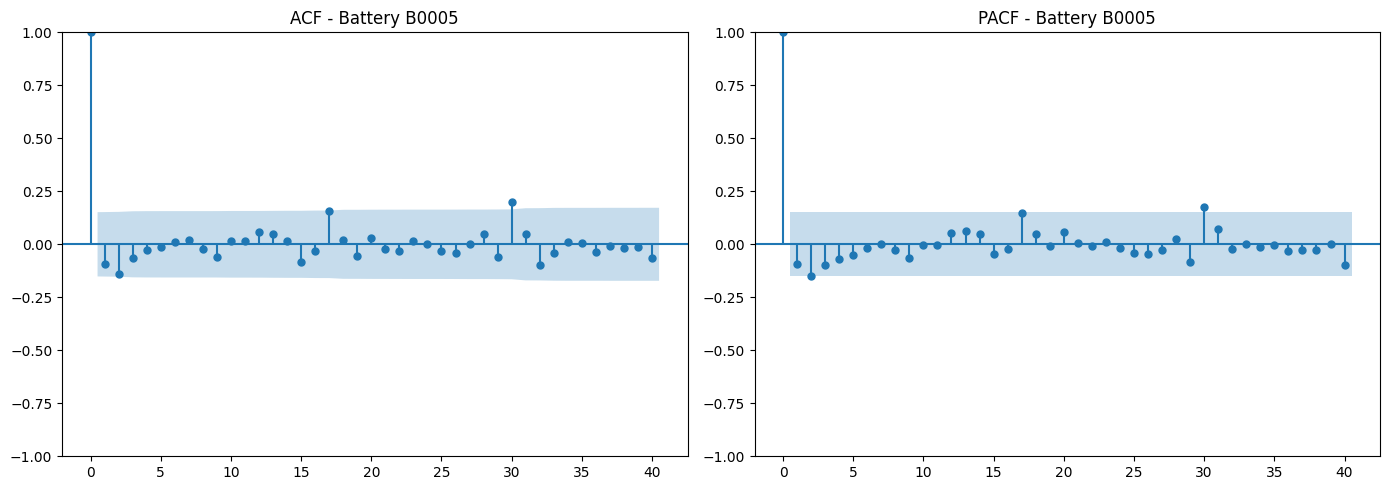

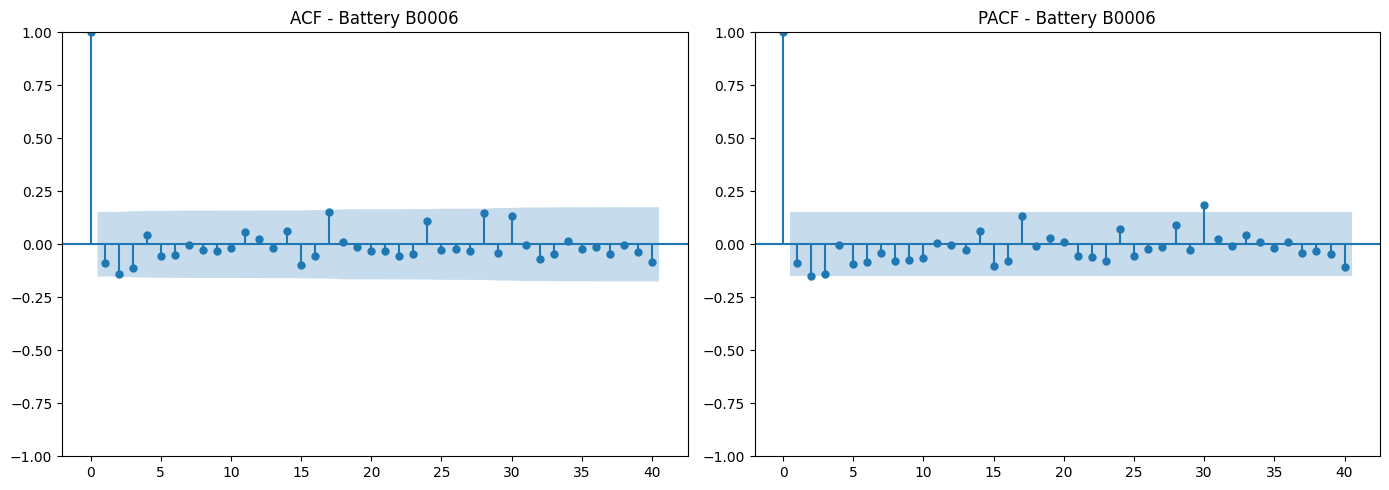

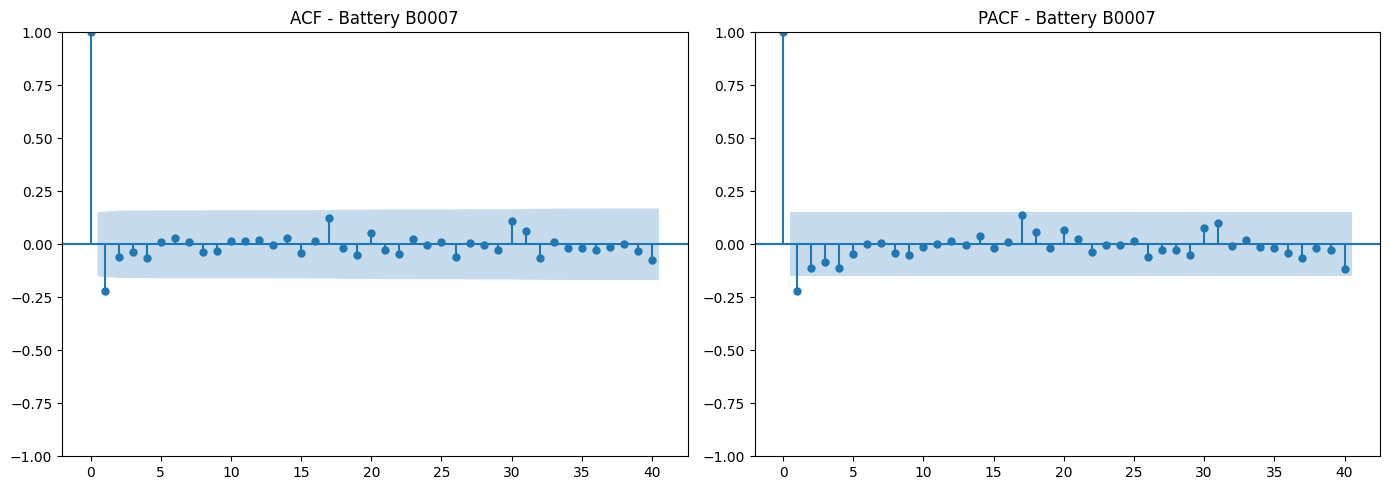

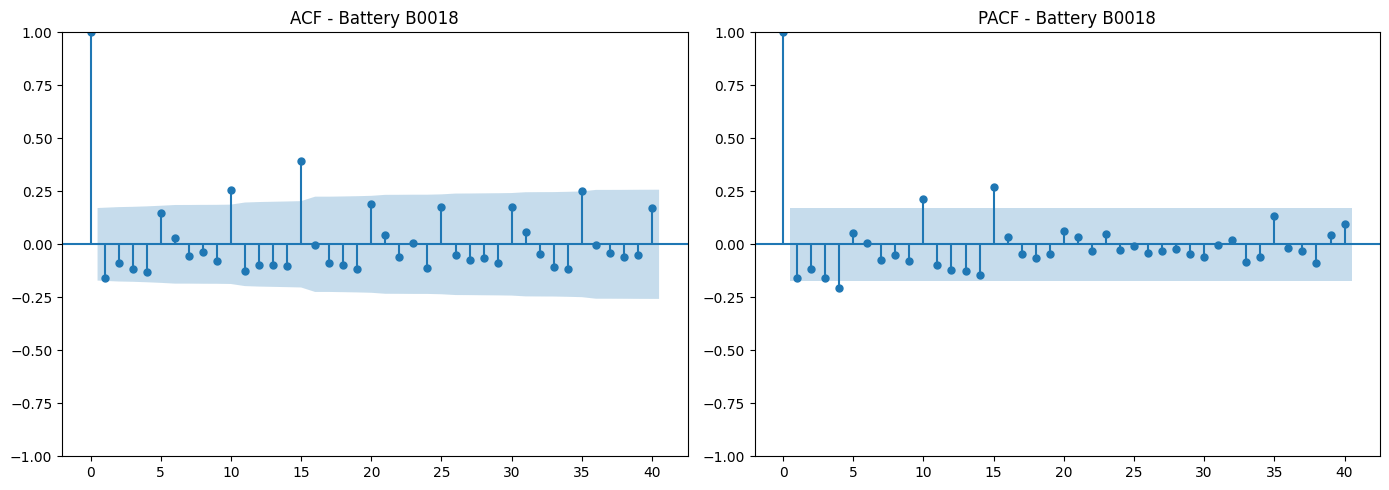

---

## 7. Model Fitting

We fitted 3 different ARIMA models on battery B0018 and ARIMA (1,1,1) for the remaining 3.

For B0018:

```python
model_orders = [(2,1,2), (3,1,2), (3,1,3)]
```

Comparison Table:

| Model        | AIC     | BIC     | Log-Likelihood |
| ------------ | ------- | ------- | -------------- |
| ARIMA(3,1,2) | -628.76 | -611.51 | 320.38         |
| ARIMA(3,1,3) | -622.04 | -601.92 | 318.02         |
| ARIMA(2,1,2) | -617.13 | -602.75 | 313.56         |

**Best Model:** ARIMA(3,1,2)

AIC and BIC both favored ARIMA(3,1,2), which balanced goodness-of-fit and model complexity.

---

## 8. Residual Diagnostics

As per Box-Jenkins, the **diagnostic checking** phase is critical. We plotted residuals of the best model:

```python
residuals = model_fit.resid
```

* Despite all batteries failing the normality check (as shown in the Q-Q plots and Shapiro test), the Ljung-Box p-values are comfortably above 0.05, indicating that residuals are white noise and uncorrelated — fulfilling one of the key assumptions for ARIMA modeling.

* The lack of normality in residuals is not unusual for engineering datasets, especially where physical degradation or sensor noise introduces skewed errors. Nonetheless, the independence of errors supports the model's reliability in forecasting.

### Residual Diagnostics Summary (Shapiro & Ljung-Box Tests)

| Battery | Gaussian (Shapiro p < 0.05) | Independent (Ljung-Box p > 0.05) | Ljung-Box p-value |
|---------|------------------------------|-----------------------------------|--------------------|
| B0005   | Not Gaussian                 | Independent                       | 0.9983             |
| B0006   | Not Gaussian                 | Independent                       | 0.9925             |
| B0007   | Not Gaussian                 | Independent                       | 0.9998             |
| B0018   | Not Gaussian                 | Independent                       | 0.4476             |


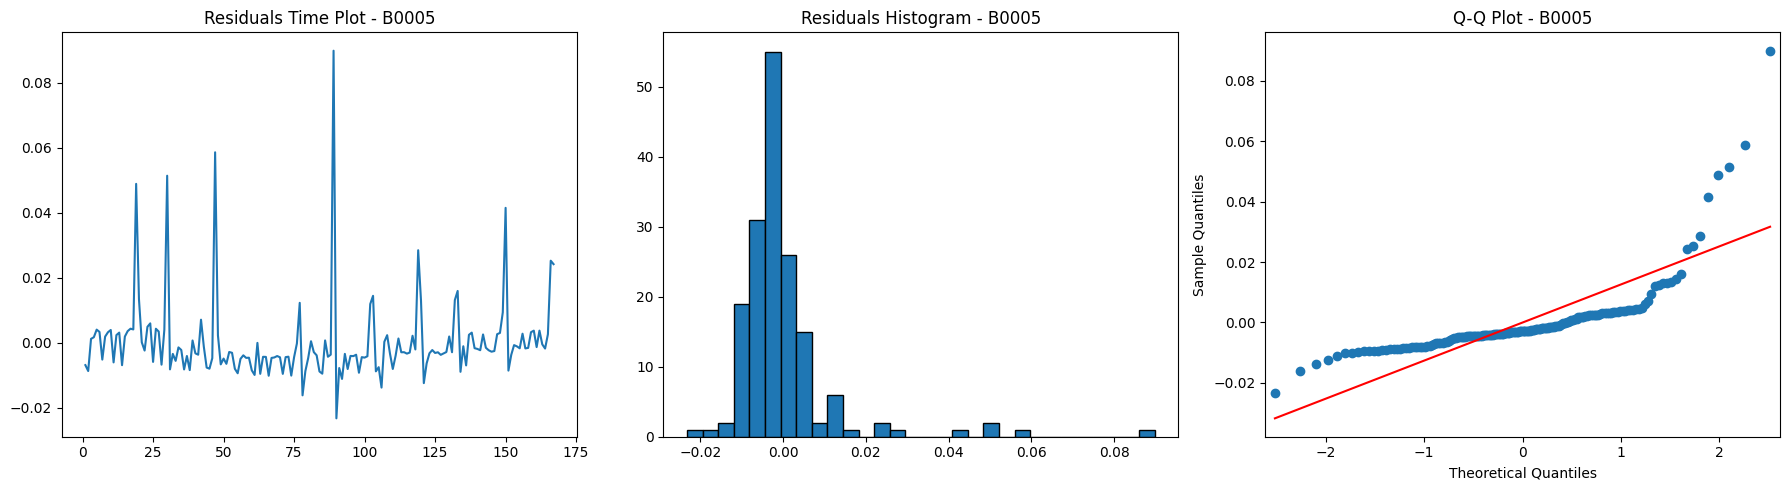

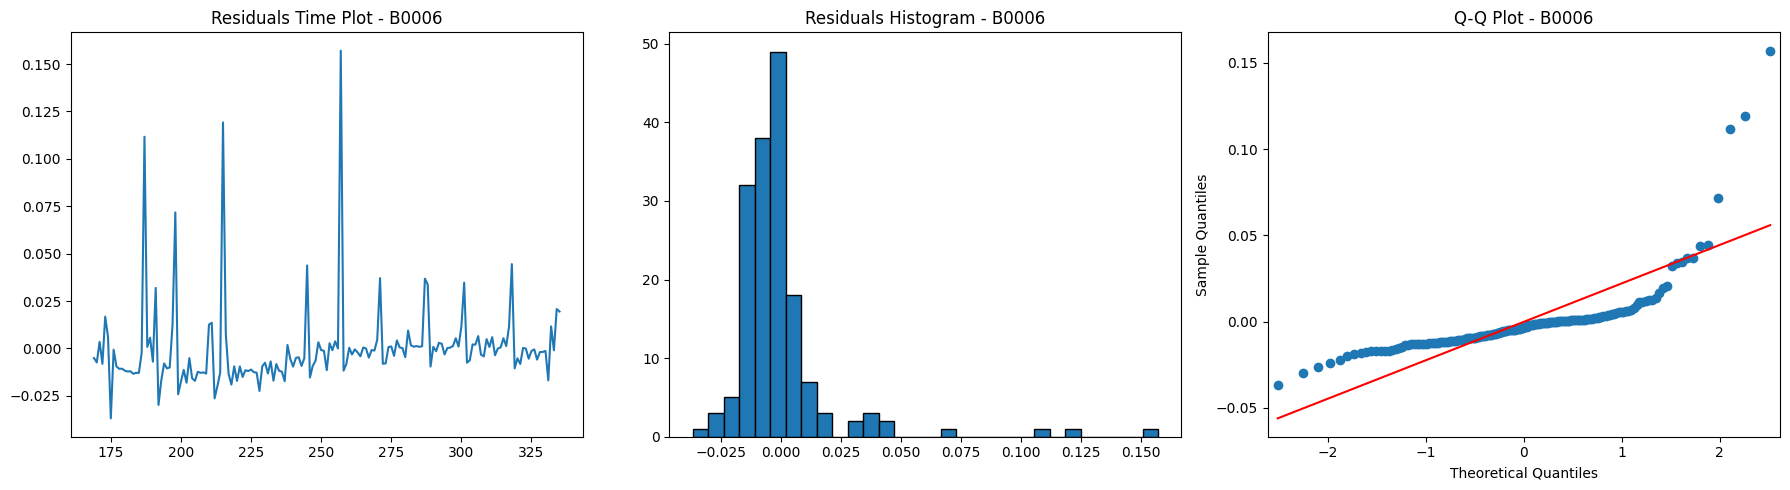

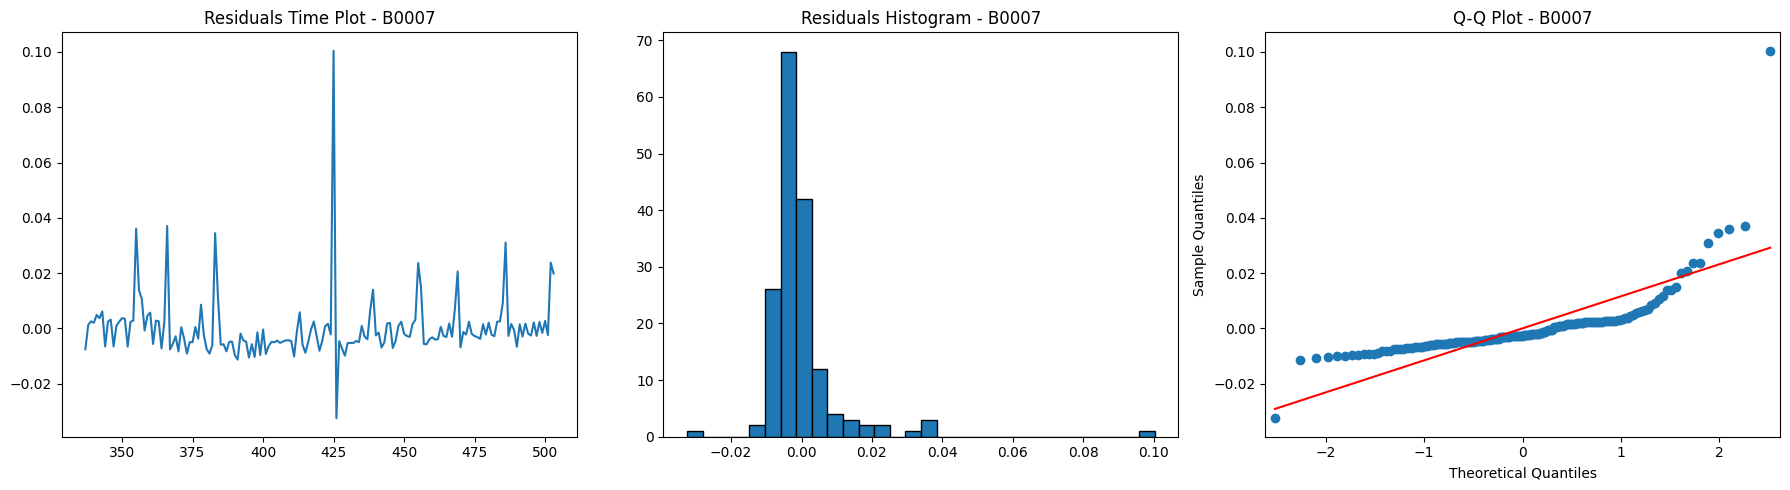

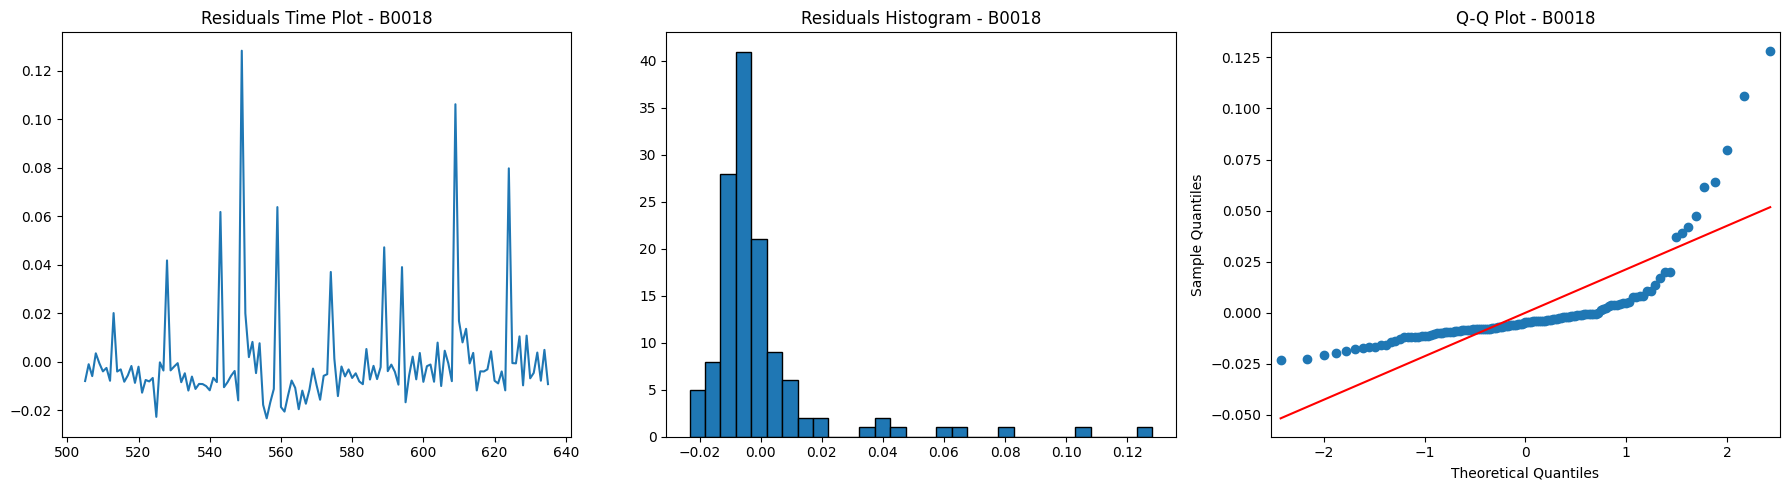

Residuals passed independence checks but failed normality, a common case in engineering datasets.

---

## 9. GARCH Modeling

We observed some heteroskedasticity in residuals and fitted a GARCH(1,1):

```python
from arch import arch_model
garch = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch.fit()
```

* GARCH captured the conditional variance well.
* High beta and low alpha suggested persistent volatility with few shock spikes.

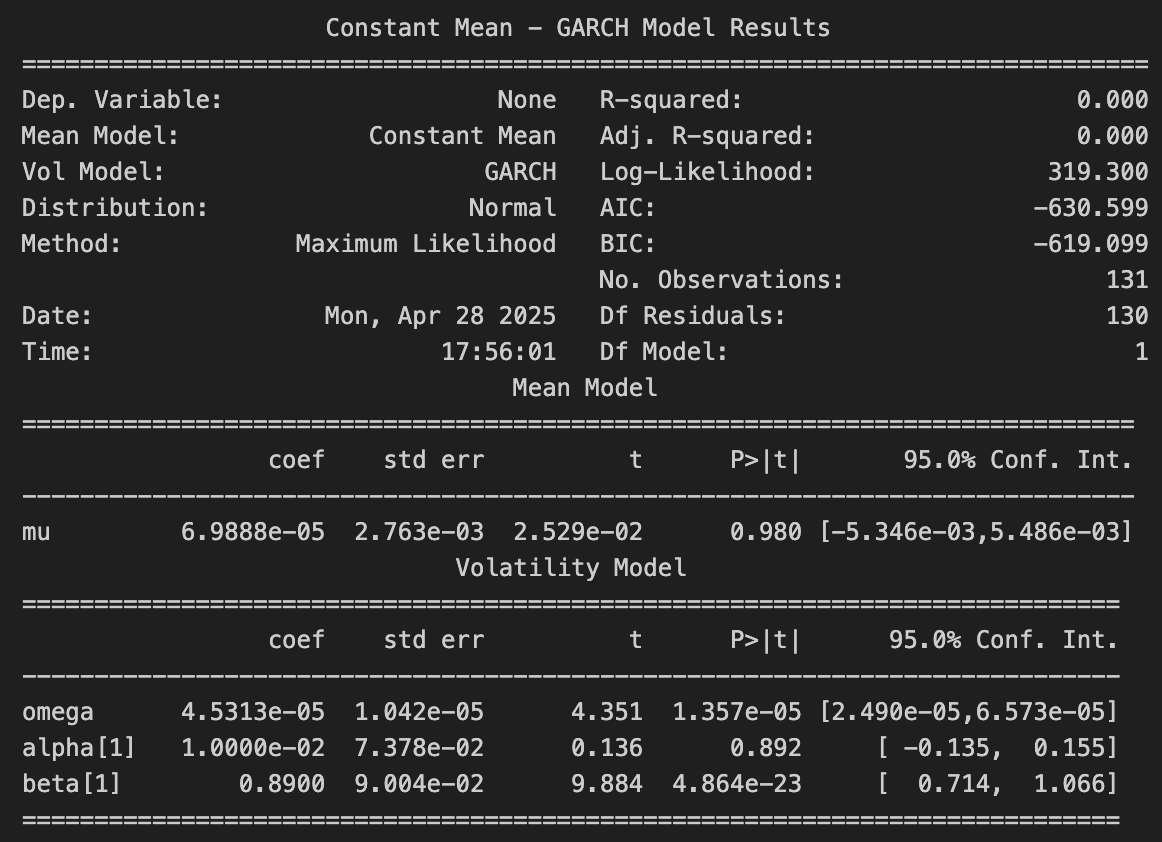

This reinforced that the battery noise behavior is time-dependent and needed variance modeling.

---

## 10. Forecasting

We performed 20-step ahead forecasts using ARIMA(3,1,2) for B0018 and ARIMA(1,1,1) for others, predicting **actual capacity** (not differenced):

```python
forecast = model_fit.get_forecast(steps=20)
```

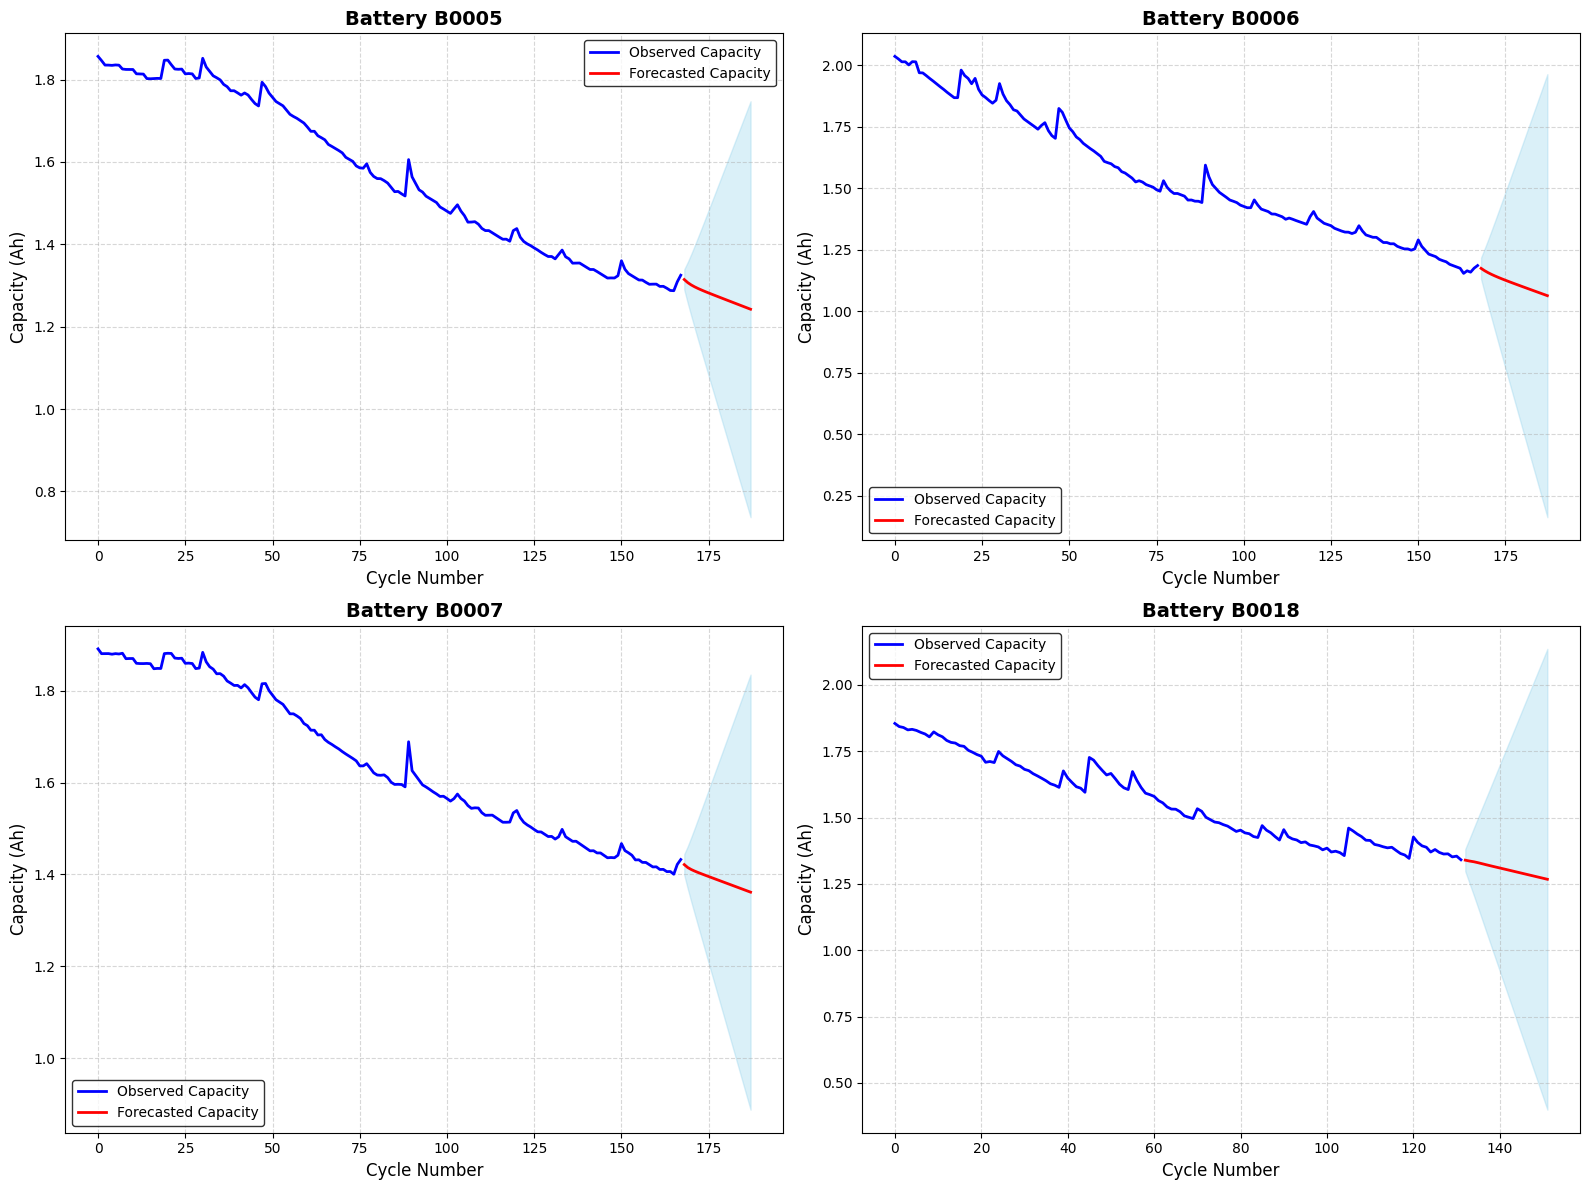

Forecasts accurately tracked downward trends and are visually in sync with test set data.

---

## 12. Conclusion

This project applied the **Box-Jenkins methodology end-to-end** on real-world battery capacity data:

* Identification: visual trends, ADF, ACF/PACF
* Estimation: ARIMA model fitting
* Diagnostic checking: residual analysis and Ljung-Box
* Forecasting: 20-step ahead + threshold prediction

The final model, ARIMA(3,1,2), provided accurate forecasts. A GARCH(1,1) extension offered additional insights into variance behavior.

### Learnings:

* ARIMA is effective for modeling capacity decay.
* Residual diagnostics are crucial before trusting predictions.
* GARCH adds value when noise patterns evolve over time.


